# Safran project

## Context

The overall objective of our project is to segment the fibers in X-ray tomographies.  
In this document, we are making tests using the following image, which is a greyscale image of a tomography.

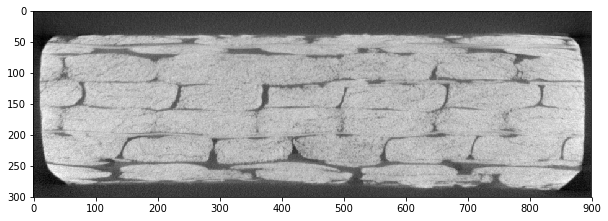

In [9]:
from skimage.external import tifffile
from skimage import img_as_float
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import cv2
from skimage.filters import threshold_yen
import numpy as np

img = tifffile.imread("test_image.tif")
img = img_as_float(img)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap=plt.get_cmap('gray'))

A first idea would be to identify the centroids of the fibers with an unsupervised learning method, in order to use some classic image processing technique to get the fibers.  
The major hindrance that we are likely to face is the fact that the fibers are not well separated, so that a direct edge detection on the static images is unlikely to work very well.

## Summary
We first explore a few classic image processing techniques.  
After that, we present a few approaches using Machine Learning and Deep Learning and discuss their application to our projet.

1. Image pre-processing  
1.a. Histogram manipulation  
1.b. Filtering  
1.c. Mathematical morphology  
2. Image Segmentation  
2.a. Thresholding  
2.b. Sobel Filter  
2.c. Watershed  
2.d. Random Walker  
2.e. Active Contour  
3. Machine Learning, Deep Learning approaches or other relevant approaches

## 1. Image pre-processing

### 1.a Histogram manipulation

It is possible to increase the contrast of an image by adjusting its histogram.
We explore here 3 histogram manipulation methods using the skimage library:
- histogram stretching
- histogram equalization
- adaptative equalization.

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import img_as_float
from skimage import exposure

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

#### Histogram Stretching

This technique improves the constrast by stretching the range of intensity to span the whole range of values. It applies a linear scaling to the image pixel values, and preserve the overall "shape" of the histogram.

To manage the outlier values in the histogram, we use the first and last percentiles instead of min and max values.

If c and d are the current values of the pecentile (let's say 2 and 98) of the histogram, and a and b are the desired min and max values (0 and 255), we have:
$$ P_{out} = (P_{in}-c)(\frac{b-a}{d-c})+a $$

On our image, it gives:

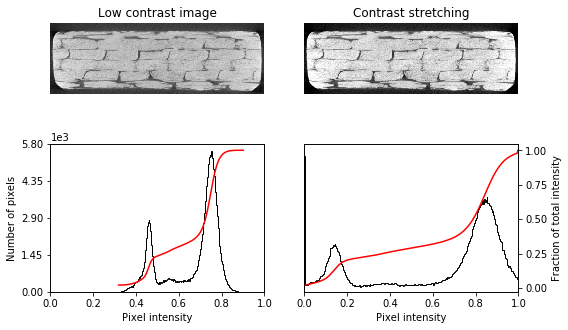

In [24]:
# Load an example image
img = tifffile.imread("test_image.tif")
img = img_as_float(img)

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 2), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 2, 1)
for i in range(1, 2):
    axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 2):
    axes[1, i] = fig.add_subplot(2, 2, 3+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

This operation has improvent the overall contrast in the image between dark parts (edges) and light parts (inner part of the fibers).  
However, the gap between the 2 intensity maxima is rather wide and it may be difficult to find an appropriate treshold for a global tresholding method for example.

#### Histogram Equalization

This method is used to increase the global contrast of images. It distributes the intensities by spreading out the most frequent values.

The method is a simple one and pretty straightforward, but a disadvantage is that it may also increase the contrast of the noise.

This method try to flatten the histogram of the image, and to change the cdf into a straight line.

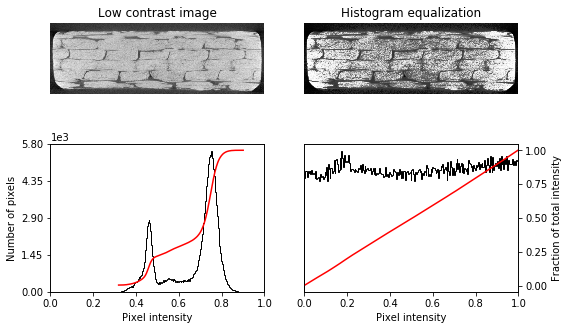

In [25]:
# Load an example image
img = tifffile.imread("test_image.tif")
img = img_as_float(img)

# Equalization
img_eq = exposure.equalize_hist(img)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 2), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 2, 1)
for i in range(1, 2):
    axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 2):
    axes[1, i] = fig.add_subplot(2, 2, 3+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 1])
ax_img.set_title('Histogram equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

Ths method flattened the histogram.  
In our case, we can see that it has increased the noise a lot.

#### Adaptative Histogram Equalization

This method differs from ordinary histogram equalization in the fact that it computes several histograms, each corresponding to a distinct section of the image.  
This method improves the local contrast and the definition of the edges in each region.

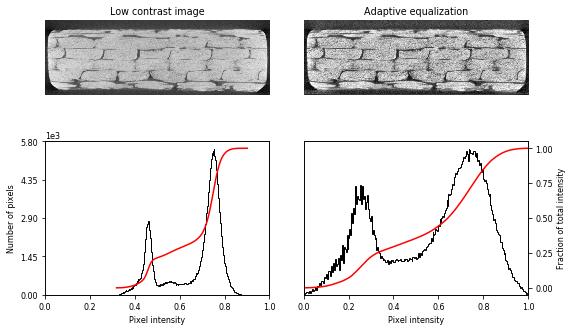

In [34]:
# Load an example image
img = tifffile.imread("test_image.tif")

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 2), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 2, 1)
for i in range(1, 2):
    axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 2):
    axes[1, i] = fig.add_subplot(2, 2, 3+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 1])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

The result show an enhanced contrast, with less noise amplification than with the global equalization.  
Besides, we kept the histogram structure with the two maxima corresponding to the inner and the edges of the fibers.

#### Histogram manipulation: Conclusion
It is a good idea to extend the range of values of the image to the full range of greyscale.  
The method which seems to be the most promising is the adaptative histogram manipulation which greatly improves the contrast. But it also amplifies the noise which has to be managed after that.

### 1.b Filtering

There are pepper and salt noises in the image. One possible way to remove those noises is using <span style="color:blue">**median filter**</span>. Median filtering is a nonlinear signal processing technique that is useful for noise suppresion in images. In one-dimensional scenario, the median filter consists of a sliding window. The center pixel in the window is replaced by the median value of pixels in the window. 

For example, if the pixels within the window is [0.1, 0.2, 0.9, 0.4, 0.5], the center pixel would be replaced by the value 0.4. In this example, if 0.9 were a noise spike (**salt noise**), it would be eliminated. For the same reason, if we encoutered an image with **pepper noise**, it can be elimiated by median filter.  

On the other hand, instead of takign the median value, <span style="color:red">**mean filter**</span> replaces the center pixel by the mean of pixels within the window. Applying mean filter is an another way to elimiate pepper and salt noises. The figure below demonstrates the operation of mean and median filter.

D:\Tsou\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:102: UserWarning: Bitdepth of 15 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


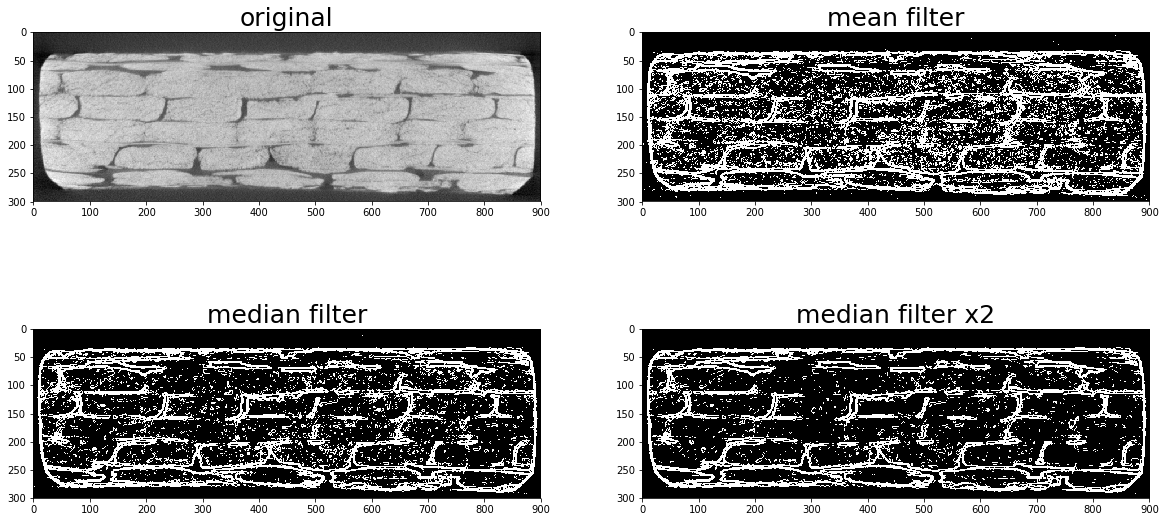

In [3]:
from skimage.external import tifffile
from skimage.filters import sobel, median
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import numpy as np
import skimage
import pdb

def meanFiltering(im, filter_size=(2, 2)):
    mean_filter = np.ones(filter_size, dtype=np.uint16)/(filter_size[0]*filter_size[1])
    img = convolve2d(im, mean_filter, mode="same")
    img = img.astype(np.float32)/65535
    return img

img = tifffile.imread("test_image.tif")
img_median1 = median(img)
img_median2 = median(img_median1)
img_median1_sobel = sobel(img_median1)>0.02
img_median2_sobel = sobel(img_median2)>0.02
img_mean = meanFiltering(img)
img_mean_sobel = sobel(img_mean)>0.02

%matplotlib inline
f, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].set_title("original", size=25)
ax[0, 0].imshow(img, cmap='gray')
ax[0, 1].set_title("mean filter", size=25)
ax[0, 1].imshow(img_mean_sobel, cmap='gray')
ax[1, 0].set_title("median filter", size=25)
ax[1, 0].imshow(img_median1_sobel, cmap='gray')
ax[1, 1].set_title("median filter x2", size=25)
ax[1, 1].imshow(img_median2_sobel, cmap='gray')
plt.show()

### 1.c Mathematical Morphology

Several segmentation techniques require to threshold the image prior to processing it. In the context of pattern detection, it is desirable to have a uniform encoding at the pattern location and in the background, as well as to have the clearest edges as possible.

Morphological operations can help to achieve this.
The morphological operations we explored are erosion, dilation, opening which is a dilation followed by an erosion and closing which is an erosion followed by a dilation.

#### Dilation

In dilation, a kernel of a specified size will slide on an image an put to 0 all pixels that have a 0 pixel under the kernel when the kernel is centered on it. Dilation operation correspond to dilating the white parts of an image like so:

![original image](figures\Morphology_1_Tutorial_Theory_Dilatation_2.png)


#### Erosion

Erosion would be the reverse operation where all pixels for which the kernel sees a black pixel when it is centerd on it is put to black. Here is an example of erosion by a 3x3 kernel:

![title](figures\Morphology_1_Tutorial_Theory_Erosion_2.png)

#### Closing

Closing is the operation of eroding and dilating with the same kernel. it has the effect of closing the small white dots in the image

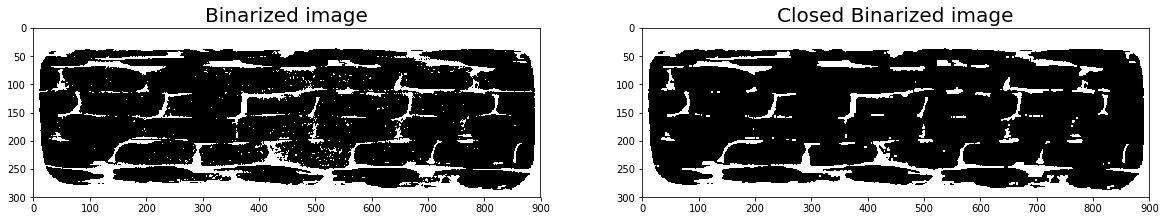

In [3]:
im=cv2.imread('test_image.tif')
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
thresh = threshold_yen(gray)
binary = gray > thresh*0.98

kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(np.uint8(binary),cv2.MORPH_CLOSE,kernel)

f ,(ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('Binarized image',size=20)
ax1.imshow(binary,cmap='Greys')
ax2.set_title('Closed Binarized image',size=20)
ax2.imshow(closing,cmap='Greys')

#### An attempt to get clear edges

We tried to using opening with flat vertical and horizontal kernels to deepen the white insertions between two bricks that we want to see as completely separate. We closed white dots before doing that. Here is an exemple of it with a 1x31 horizontal kernel and a 21x1 vertical kernel

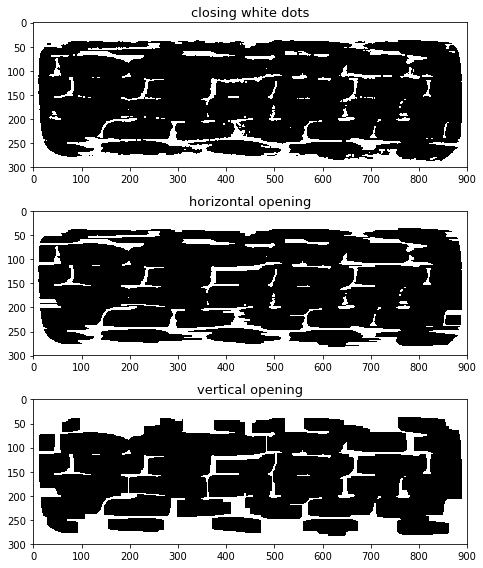

In [14]:
kernel1 = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(np.uint8(binary),cv2.MORPH_CLOSE,kernel1)

kernel2 = np.ones((1,31),np.uint8)
opening1 = cv2.morphologyEx(closing,cv2.MORPH_OPEN,kernel2)

kernel3 = np.ones((21,1),np.uint8)
opening2 = cv2.morphologyEx(opening1,cv2.MORPH_OPEN,kernel3)

f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(8,8))
ax1.set_title('closing white dots', size = 13)
ax1.imshow(closing,cmap='Greys')
ax2.set_title('horizontal opening',size = 13)
ax2.imshow(opening1, cmap='Greys')
ax3.set_title('vertical opening', size = 13)
ax3.imshow(opening2, cmap='Greys')
f.tight_layout()

Using these operations, we can separate some of the fibers which can be usefull to further use segmentation techniques that require initializing regions such as watershed. However, we didn't manage to get a clear separation of all the fibers without damaging the image too much

## 2. Image Segmentation

### 2.b Sobel Filter

Sobel filter is often used to detect edges in images. Technically, it is a **discrete differentiation operator**. At each point in an image, the output of Sobel filter is the norm of gradient of this pixel. The way to compute the gradient is to apply vertical and horizontal derivative to the image.

![](./figures/sobel_filters.png)

And then we can compute the norm of gradient. 

$$\displaystyle G_x = \left[\begin{array}{ccc} -1&0&1  \\ -2&0&2 \\ -1&0&1\end{array} \right] * A \hspace{4ex} G_y = \left[\begin{array}{ccc} 1&2&1  \\ 0&0&0 \\ -1&-2&-1\end{array} \right] * A$$

$$\displaystyle G = \sqrt{G_x^2 + G_y^2}$$

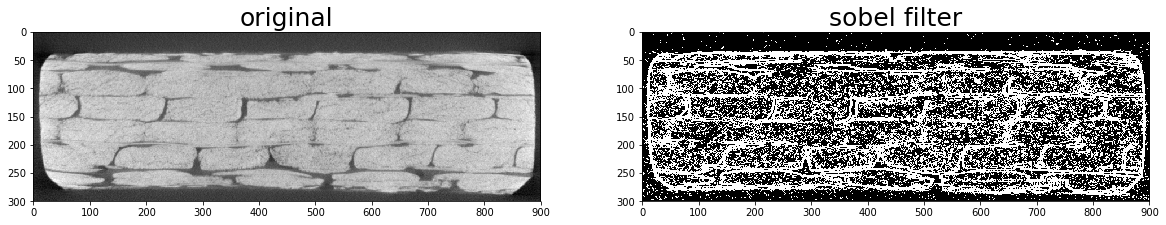

In [4]:
from skimage.external import tifffile
from skimage.filters import sobel, median
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import numpy as np
import skimage

img = tifffile.imread("test_image.tif")
img_sobel = sobel(img)>0.02

%matplotlib inline
f, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("original", size=25)
ax[0].imshow(img, cmap='gray')
ax[1].set_title("sobel filter", size=25)
ax[1].imshow(img_sobel, cmap='gray')
plt.show()

### 2.c Watershed

#### thresholding

In [4]:
thresh = threshold_yen(gray)
binary = gray > thresh*0.98

#### closing white dots

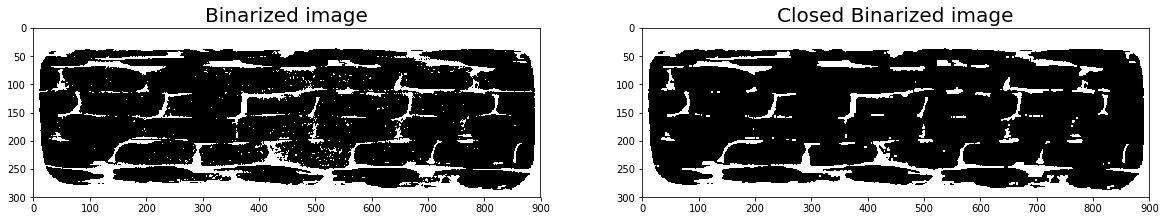

In [5]:
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(np.uint8(binary),cv2.MORPH_CLOSE,kernel)

f ,(ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('Binarized image',size=20)
ax1.imshow(binary,cmap='Greys')
ax2.set_title('Closed Binarized image',size=20)
ax2.imshow(closing,cmap='Greys')

#### Getting the sure background areas

In [6]:
sure_bg = cv2.dilate(closing,kernel,iterations=2)
sure_bg = cv2.bitwise_not(sure_bg)

#### Getting the distance map

to better separate the fibers, we use the distance transform with a distance function as such:
$d((x_1,y_1),(x_2,y_2))=|x_1-x_2|+\alpha{|y_1-y_2|}$ where $\alpha$ is a parameter of the model.
This will let the value in the distance image of points from upper and lower edges to be greater lower than that of the points of left or right edges of each fibers which will hopefully let us enhance the horizontal separation when thresholding the distance image.

In [7]:
alpha = 10

def distance(x1,y1,x2,y2):
    return abs(x1-x2)+alpha*abs(y1-y2)

vect_distance = np.vectorize(distance)

In [10]:
indices_distance = ndi.distance_transform_edt(closing,return_distances=False,return_indices=True)
indices_distance_lignes = indices_distance[0]
indices_distance_colonnes = indices_distance[1]

indices_base = np.indices(closing.shape)
indices_base_ligne = indices_base[0]
indices_base_colonnes = indices_base[1]

distance = vect_distance(indices_base_colonnes,indices_base_ligne,
                         indices_distance_colonnes,indices_distance_lignes)

#### Thresholding the distance map

In [13]:
thresh_on_distance = 0.32*distance.max()
sure_fg = distance > thresh_on_distance

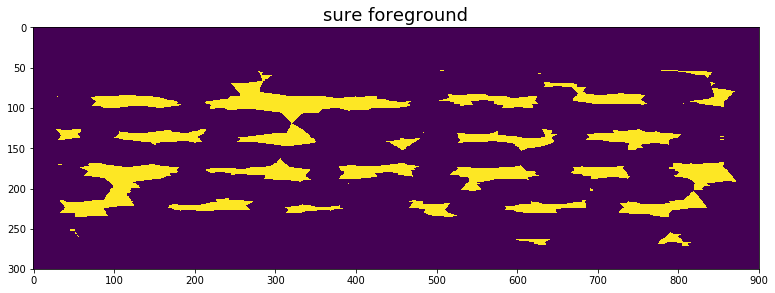

In [14]:
f,ax = plt.subplots(1,1,figsize=(13,13))
ax.set_title('sure foreground', size=18)
ax.imshow(sure_fg)

#### Getting regions with unknow status

In [15]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#### Using watershed segmentation on the above information

Each connected component of the sure_foreground map above get a label in the markers map ( from 2 to n+1, if n connected components in the sure_fg image).
The sure_background part also has a label his own (1), and the unknown part is labeled 0

In [17]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==254]=0

markers = cv2.watershed(im,markers)

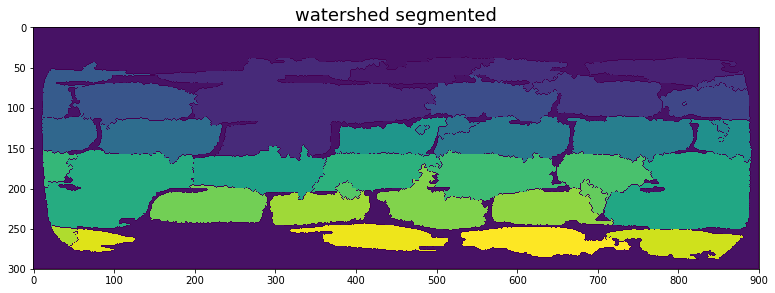

In [18]:
hough_linef,ax = plt.subplots(1,1,figsize=(13,13))
ax.set_title('watershed segmented',size=18)
ax.imshow(markers)

## 3. Machine Learning, Deep Learning or other relevant approaches

### An Unsupervised Approach for Overlapping Cervical Cell Cytoplasm Segmentation
Pranav Kumar, S L Happyy, Swarnadip Chatterjeez, Debdoot Sheety, Aurobinda Routrayy

This paper presents a method which automatically detect cel clumps in an image, and then segment them using an unsupervised method.

First, the cell clumps are segmented using a regional minima method. (finding the connex components based on the pixel intensities).  
After this step, the nuclei of the cells are detected for each cell clumps using a Otsu tresholding technique (separate foreground and background to minimize the intra-class variance).  
The last step is to propagate the boudaries from the nuclei using a level set method (like watershed).

__Conclusion__  
The principal limitation of what is done here, for our case, is the necessity to find a marker inside each fiber.

### Cell Detection in Microscopy Images with Deep Convolutional Neural Network and Compressed Sensing
Yao Xue and Nilanjan Ray

In this paper, a method to segment cells using compressed sensing and a Deep CNN is described.

The cell centers from different axes (let's say L axes) are encoded in a vector.  
The decoding step consist in an optimization problem giving L positions for each ground truth cell centers. The cells positions are then obtained thanks to a clustering method. (In facts, each cell is detected L times).

The CNN is used to get the encoded vector from the beginning image.

__Conclusion__
The major setback of this method is that the CNN is to be trained, which we cannot really afford.  
However, the encoding method is interesting.

### Using optical flow to infer edges

One of the major setback of our data is that the edges are dicontinuous so that directly using a classic image processing method to separate fibers is not likely to work. Besides, we are trying to fin an unsupervise method so that we do not need labeled data which are difficult to get.

One method to explore to retrieve the edges is to consider our data as a video in which the edges are occluded and where our fibers are moving.  
Different papers treat this kind of problems

__Unsupervised Learning of Edges__  
Yin Li, Manohar Paluri, James M. Rehg, and Piotr Dollar  
This paper presents an approach to pre-train edge detectors without human supervision, using motion.

__Contour Detection and Image Segmentation__  
Michael Randolph Maire  
Chapter 4   
The paper consider the motion gradient between two consecutive frame to detect moving objects.
It extends this method to detect boundary occlusions.

__Occlusion Boundary Detection and Figure/Ground Assignment from Optical Flow__
Patrik Sundberg, Thomas Brox, Michael Maire, Pablo Arbelaez, and Jitendra Malik
The paper proposes a contour and region detector for video data that exploits motion cues and distinguishes occlusion boundaries from internal boundaries based on optical flow.

__Conclusion__  
The motion gradient method can be promising and can be a basis to retrieve missing edges on our data.

### Using concave points

The edges of our images are discontinuous but the presence of concave points can give hints of the presence of an edge between different fibers.


__Splitting touching cells based on concave-point and improved watershed algorithms__  
Hong Song,Qingjie Zhao, Yinghong Liu
The paper is paying :/  
But seems interesting  
GET THE PAPER on Springer

__Touching Cells Splitting by Using Concave Points and Ellipse Fitting__  
Xiangzhi Bai, Changming Sun, Fugen Zhou  
This paper proposers a method to segment clumps of cells using concave points and ellipse fitting. In our case, using the concave points can be a really good solution to infer missing edges. The ellipse fitting part seems to be too specific to cells but is needed for the cases in which the edges are not smooth.
To get rid of this last steps, it may be needed to find another type of fitting, or to do the first part on an already pre processed image.

__Conclusion__
Using concave point to retrieve missing edges seems to be promising

### Using Hough transform

Another method which can be used to link edges with discontinuities is to use the Hough transform.

The principle is the following. In general, straight lines are represented by their equation 
$$ y = ax+b $$
We shift from this representation to the polar representation:
$$ (r,\theta) $$
In the new plane, each pixel of the original image correspond to a sinusoidal curve (corresponding to every straight ligne that can go through this pixel), and each straight line of the original image correspond to one point in the Hough space.

Therefore, we can :
- Use the Hough transform on the original image
- In the Transform, find the maximal values (corresponding to the edges detected)
- For each edge detecte in the Hough plane, link pixels that are closer than a certain treshold.

### U-net: Convolutional Neural Networks for Biomedical Image Segmentation

This paper aim to deal with segmentation problem with convolutoinal neural network (CNN) autoencoder, or so-called U-net. 
![](./figures/U-net.png)

Some remarks:
1. Loss function is defined as: $$E = \sum_{x} w(x) \bigg(t \log p(x) + (1-t) \log (1-p(x)) \bigg) $$
    * $x$ is each pixel in the image
    * $w(x)$ is a weight map that emphasize the importance of the border pixels
    * $p(x)$ is the output of U-net (using sigmoid functio for the last layer)
2. The weight map is defined as : $$w(x)= w_c(x) + w_0 \cdot \exp \bigg( -\frac{(d_1(x)+d_2(x))}{2\sigma^2} \bigg)$$
    * $w_c(x)$ is the weight map to balance the class frequencies
    * $d_1(x)$ is the distance to the border of the nearest cell
    * $d_2(x)$ is the distance to the border of the second nearest cell
3. Since we only have small number of training images, data augmentation is essential to teach the U-net the desired invariance and robustness: ***Shift, rotation, deformation*** are adopted for data augmentation.

### W-Net: A Deep Model for Fully Unsupervised Image Segmentation

This paper use to U-net to deal with unsupervised image segmentation problem. The first U-net (U-enc) encodes the image into segmented one, then the second U-net (U-dec) go from the segmentation to a reconstructed image. Then they minimize the reconstruction error and segmentation error iteratively. 
![](./figures/W-net.png)

Some remarks:
1. The depth-wise convolution is used in order to extract features from spatial and corss-channel independently.
2. The U-enc will output a segmented image of size $H\times W \times K$ where K is the number of segmentation classes. We can obtain a K-class prediction for each pixel by $\arg\max$. The normalized cut $Ncut$ is used as a criterion for the segmentation:
$$ \begin{aligned}
J_{soft-Ncut}(V) &= \sum_{k=1}^K \frac{cut(A_k, V-A_k)}{assoc(A_k, V)} \\
&= K- \sum_{k=1}^K \frac{assoc(A_k, A_k)}{assoc(A_k, V)} \\
&= K- \sum_{k=1}^K \frac{\sum_{u\in V, v\in V} w(u, v) p(u\in A_k)p(v\in A_k)}{\sum_{u\in A_k, t\in V} w(u, t)p(u\in A_k)}
\end{aligned}$$
where $A_k$ is set of pixels in segment $k$, $V$ is the set of all pixels, and $w$ measures the weight between two pixels. 
    * Idea of normalized cut: measure the dissimilarity between the classes and the smilarity within the class.
3. The reconstruction error is given by:
$$J_{reconstr} = \big|\big| \mathbf{X} - \mathbf{U}_{Dec} (\mathbf{U}_{Enc} (\mathbf{X}; \mathbf{W}_{Enc}); \mathbf{W}_{Dec})\big|\big| ^2_2$$
4. Postprocessing: 
    * fully-connected CRF
    * Hierarchical segmentation 
        * Oriented watershed transform 
        * Ultrametric contour map